<a href="https://colab.research.google.com/github/agamthind96/Deep-Learning-Projects/blob/main/Transfer_learning_in_TensorFlow_Part_2(Fine_Tuning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer-Learning with TensorFlow Part-2 : Fine Tuning

In [ ]:
# Check if we are using the GPU
!nvidia-smi

Sun Dec  5 14:18:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing Helper Functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
    

--2021-12-05 14:18:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-05 14:18:54 (75.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note** : When runtime disconnects, helper function will be deleted from colab which has to be downloaded again.

## Let's get some data

This time we are going to see that how we can use the pre-trained model with *tf.keras.applications* and apply them to our own problem.

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-12-05 14:18:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.197.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   144MB/s    in 1.1s    

2021-12-05 14:18:59 (144 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and sub-directories are there in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [ ]:
# Create training and test directory paths.
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE=(224, 224)
BATCH_SIZE=32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
# Check out the class_names of our dataset
class_names = train_data_10_percent.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.51000000e+02 1.52000000e+02 1.56000000e+02]
   [1.51596939e+02 1.52596939e+02 1.56596939e+02]
   [1.51719391e+02 1.52719391e+02 1.56719391e+02]
   ...
   [1.43960007e+02 1.73801865e+02 1.25521248e+02]
   [1.27902870e+02 1.62117203e+02 1.11045753e+02]
   [1.05974419e+02 1.44974411e+02 8.99744186e+01]]

  [[1.49928574e+02 1.50928574e+02 1.54928574e+02]
   [1.49994904e+02 1.50994904e+02 1.54994904e+02]
   [1.50928574e+02 1.51928574e+02 1.55928574e+02]
   ...
   [1.74505493e+02 2.05862701e+02 1.56291229e+02]
   [1.13684517e+02 1.47898849e+02 9.68171921e+01]
   [1.29642166e+02 1.68550323e+02 1.13596245e+02]]

  [[1.49000000e+02 1.50000000e+02 1.54000000e+02]
   [1.49198975e+02 1.50198975e+02 1.54198975e+02]
   [1.50000000e+02 1.51000000e+02 1.55000000e+02]
   ...
   [1.26102531e+02 1.57628082e+02 1.07719917e+02]
   [1.58250473e+02 1.93082123e+02 1.39679047e+02]
   [1.33575104e+02 1.69998672e+02 1.15080215e+02]]

  ...

  [[9.50714493e+01 9.50714493e+01 9.30714493e+01]
   [9

## Model 0 : Build a **Transfer Learning** model using the Keras Functional API

The Sequential API is straight forward, it runs our layers in sequential layer.

But the functional-API gives us more flexibilty with our models.

In [ ]:
# 1. Create Base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained weights are not updated during training)
base_model.trainable = False

# 3. Create inputs into our model.
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If usin a model like ResNet50V2 you will need to normalize inputs 
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model.
x = base_model(inputs)
print(f"Shape after passing inputs through base model : {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling 2D : {x.shape}")

# 7. Create the output activation layer.
output = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with outputs into a model.
model_0 = tf.keras.Model(inputs, output)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer="adam",
                metrics=["accuracy"])

# 10. Fit the model
history = model_0.fit(
    train_data_10_percent,
    steps_per_epoch = len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(0.25*len(test_data)),
    epochs=10,
    callbacks=[create_tensorboard_callback(dir_name="Transfer_learning",
                                           experiment_name="10_percent_feature_extraction")]
)



16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model : (None, 7, 7, 1280)
Shape after Global Average Pooling 2D : (None, 1280)
Saving TensorBoard log files to: Transfer_learning/10_percent_feature_extraction/20211205-141911
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 24s 359ms/step - loss: 1.9336 - accuracy: 0.3827 - val_loss: 1.3938 - val_accuracy: 0.6743
Epoch 2/10
24/24 [==============================] - 9s 361ms/step - loss: 1.1701 - accuracy: 0.7413 - val_loss: 0.9363 - val_accuracy: 0.7862
Epoch 3/10
24/24 [==============================] - 9s 358ms/step - loss: 0.8392 - accuracy: 0.8173 - val_loss: 0.7702 - val_accuracy: 0.8059
Epoch 4/10
24/24 [==============================] - 9s 357ms/step - loss: 0.6919 - accuracy: 0.8373 - val_loss: 0.6676 - val_accuracy: 0.8207
Epoch 5/10
24/24 [==============================] - 7s 267ms/step - loss: 0.5913 - accuracy: 0.8627 - val_loss: 0.6378 - val_accuracy: 0.8158
Epoch 6/10
24/24 [==============================] - 9s 357ms/step - loss: 0.5159 - accuracy: 0.8840 - val_loss: 0.5918 - val_accuracy: 0.8322
Epoch 7/10
24/24 [==============================] - 9s 358ms/step - loss: 0.4675 - accuracy: 0.9040 - val_loss: 0.5505 - val_accuracy: 0.8503
Epoch 8/10
24/24

In [ ]:
# Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 11s 135ms/step - loss: 0.4963 - accuracy: 0.8592


[0.496263712644577, 0.8592000007629395]

In [ ]:
# Check the layers in our base model.
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
# Let's look at the summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# Let's look at the summary of our model.
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


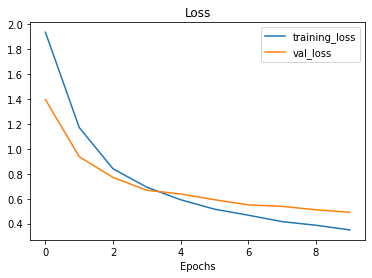

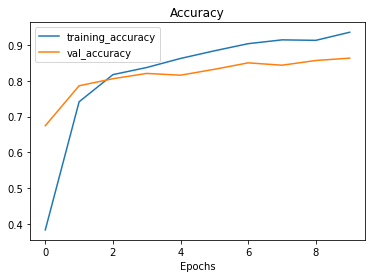

In [ ]:
# Check out or results using Loss Curves.
plot_loss_curves(history)

## Getting a Feature Vector from trained model.

Let's demonstrate the Global Average Pooling 2D layer.

We have a tensor after our model goes through base_model of shape(None,7,7,1280), but when it passes through the GloablAveragePooling2D layer it converts into Tensor of shape (None, 1280).

Let's use a similar shaped tensor of (1,4,,4,3) and then pass it to GlobalAveragePooling2D layer.

In [ ]:
# Define the input_shape
input_shape = (1,4,4,3)

# Create the random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random Input tensor : \n {input_tensor} \n")


Random Input tensor : 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 



In [ ]:
# Pass the input_tensor through GlobalAveragePoolinLayer2D.
global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_average_pooling_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [ ]:
# Let's replicate the GlobalAveragePooling2D.
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [ ]:
# Try to do same task as above for GlobalMaxPooling2D.
global_max_pooling_layer = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
global_max_pooling_layer


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

In [ ]:
# Let's replicate the GlobalMaxPooling2D.
tf.reduce_max(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

### What is Feature Vector ?

A Feature vector is a learned representation of the input data ( a compressed form of the input data based on how model sees it).



## Running a series of Transfer Learning experiments.

We have seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data. Let's set up a bunch of experiments to find out this.

* **model_1** - use feature extraction transfer learning with 1% of the training data with data augmentation.
* **model_2** - use feature extracton transfer learning with 10% of training with data augmentation.
* **model_3** - use fine-tuning transfer learning on 10% of the training data with data augmentation.
* **model_4** - use fine-tuning transfer learning on 100% of the training data with data augmentation.

**Note** : Throughout all experiments, the same dataset will be used to evaluate our model

### Getting and preprocessing data for model_1.

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2021-12-05 14:21:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 74.125.69.128, 64.233.183.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   173MB/s    in 0.7s    

2021-12-05 14:21:29 (173 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create Training and Test dirs.
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

In [ ]:
# Setup Data Loaders.
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
                        train_dir_1_percent,
                        label_mode="categorical",
                        image_size=IMG_SIZE,
                        batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
              test_dir,
              label_mode="categorical",
              image_size=IMG_SIZE,
              batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding Data Augmentation right into the model.

To add data augmentation right into our models, we can use layers inside :

* tf.keras.layers.experimental.preprocessing()

https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing?version=nightly

* Preprocessing of images (augmenting them) happens over GPU rather than CPU which is much faster.
* Image Data Augmentation happens only during training, so we can still export our whole model and use it elsewhere.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms etc.
data_augmentation = keras.Sequential([
          preprocessing.RandomFlip("horizontal"),
          preprocessing.RandomRotation(0.2),
          preprocessing.RandomZoom(0.2),
          preprocessing.RandomHeight(0.2),
          preprocessing.RandomWidth(0.2),
          # preprocessing.Rescale(1./255)   For models like ResNetV2, but for current model it is already built-in.
], name="data_augmentation")

### Visualize our data augmentation layer ( and see what happens to our data)

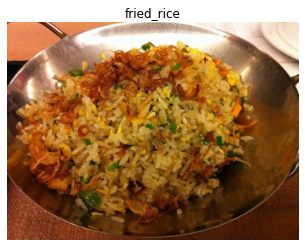

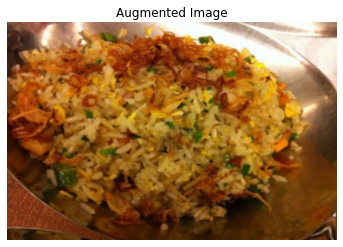

In [ ]:
# View a random image and convert it to its augmented version.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(target_class)
plt.axis('off');

# Now let's plot our augmented image
augmented_image = data_augmentation(img)
plt.figure()
plt.imshow(augmented_image/255.)
plt.title("Augmented Image")
plt.axis("off");

### Model 1 : Feature Extraction Transfer Learning on 1% of the data with data augmentation.


In [ ]:
# Setup input shape and base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer.
x = data_augmentation(inputs)

# Give base model inputs after augmentation and don't train it.
x = base_model(x, training=False)

# Pool output features of base model.
x = layers. GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put the dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make the model using inputs and output.
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="Transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

 



Saving TensorBoard log files to: Transfer_learning/1_percent_data_aug/20211205-142137
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3/3 [==============================] - 16s 4s/step - loss: 2.4041 - accuracy: 0.0857 - val_loss: 2.2657 - val_accuracy: 0.1546
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1872 - accuracy: 0.2286 - val_loss: 2.1382 - val_accuracy: 0.2253
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9725 - accuracy: 0.4143 - val_loss: 2.0441 - val_accuracy: 0.2747
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.8236 - accuracy: 0.5429 - val_loss: 1.9692 - val_accuracy: 0.3257
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.6575 - accuracy: 0.6143 - val_loss: 1.8762 - val_accuracy: 0.3832


In [ ]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluating on full test set.
model_1.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 1.8352 - accuracy: 0.4360


[1.8351601362228394, 0.4359999895095825]

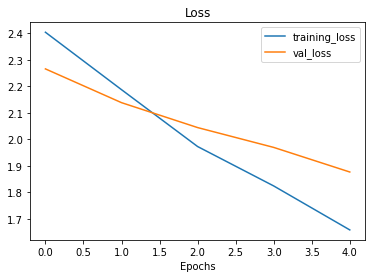

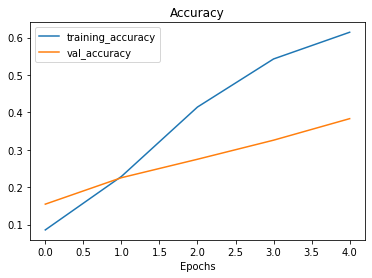

In [ ]:
# Plotting loss curves for model_1
plot_loss_curves(history_1_percent)

## Model 2 : Feature Extraction Transfer Learning model with 10% of data and data augmentation.

In [ ]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# How many images are there in our directory?
walk_through_dir(dir_path="10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [ ]:
# Create model 2 with data augmentation built in.
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build Data Augmentation layer
data_augmentation = Sequential([
          preprocessing.RandomFlip("horizontal"),
          preprocessing.RandomHeight(0.2),
          preprocessing.RandomWidth(0.2),
          preprocessing.RandomZoom(0.2),
          preprocessing.RandomRotation(0.2)
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224,224,3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create the inputs and outputs (including layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x,training=False) # Pass augmented images to base model but keep it in inference mode, this also ensures that batch norm layers also doesn't get updated.
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2d")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

 

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckPoint callback

The ModelCheckPoint callback intermediately saves our model(teh full model or just the weights) during training. This is useful so we can come and start where we left off

In [ ]:
# Set check point path.
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckPoint callback that saves model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq="epoch",
                                                        verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [ ]:
initial_epochs=5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="Transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: Transfer_learning/10_percent_data_aug/20211205-142249


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0335 - accuracy: 0.3293
Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 26s 776ms/step - loss: 2.0335 - accuracy: 0.3293 - val_loss: 1.4620 - val_accuracy: 0.6908
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3719 - accuracy: 0.6933
Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 752ms/step - loss: 1.3719 - accuracy: 0.6933 - val_loss: 1.0699 - val_accuracy: 0.7648
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0675 - accuracy: 0.7360
Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 569ms/step - loss: 1.0675 - accuracy: 0.7360 - val_loss: 0.8467 - val_accuracy: 0.8043
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.9013 - 

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.6957 - accuracy: 0.8020


[0.6957499980926514, 0.8019999861717224]

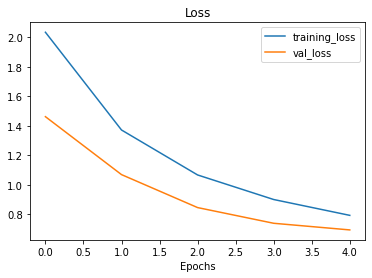

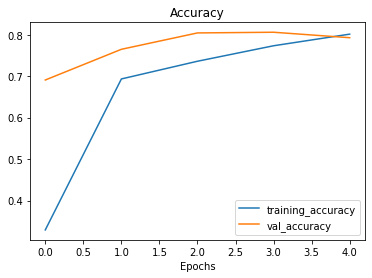

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpoints weights

Loading in checkpointed weights returns a model to a specific checkpoint.


In [ ]:
# Load in saved model weights  and evaluate model.
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_result = model_2.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.6957 - accuracy: 0.8020


## Model 3 : Fine tuning an existing model on 10% of data

**Note** : Fine-Tuning usualy works best after training a Feature-Extraction model for a few epochs with large amoutn of custom data.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are these layers trainable ?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f7e2f203e50> True
<keras.engine.sequential.Sequential object at 0x7f7e2f1d0a50> True
<keras.engine.functional.Functional object at 0x7f7e2ed09c10> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f7e2f1d0a10> True
<keras.layers.core.dense.Dense object at 0x7f7e2ede8d10> True


In [ ]:
# What layers are in our base model (EfficientNetB0) and are they trainable ?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# How many trainable variables are there in our model ?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin Fine-Tuning, let's start by setting the last 10 layers of our base_model = True
base_model.trainable=True

# Freeze all layers except last 10
for layer in base_model.layers[:len(base_model.layers)-10]:
  layer.trainable=False

In [ ]:
# Recompile the model (we have to recompile our model every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # While Fine-Tuning, multiply learning rate by (1/10) as a thumb-rule
                metrics=["accuracy"])




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


> **Note** : When using Fine-Tuning it's best practise to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least by 10x. 

More information can be found on https://arxiv.org/abs/1801.06146

In [ ]:
# Check which layers are tunable(trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Now check how many trainable variabel are there in abse model
print(len(model_2.layers[2].trainable_variables))

10


In [ ]:
# Fine-tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # Start training from last epoch of last model
                                               callbacks=[create_tensorboard_callback(dir_name="Transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])



Saving TensorBoard log files to: Transfer_learning/10_percent_fine_tune_last_10/20211205-144531


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 5/10
24/24 [==============================] - 95s 4s/step - loss: 0.6988 - accuracy: 0.8000 - val_loss: 0.5565 - val_accuracy: 0.8438
Epoch 6/10
24/24 [==============================] - 88s 4s/step - loss: 0.5600 - accuracy: 0.8373 - val_loss: 0.5530 - val_accuracy: 0.8355
Epoch 7/10
24/24 [==============================] - 76s 3s/step - loss: 0.4962 - accuracy: 0.8520 - val_loss: 0.5156 - val_accuracy: 0.8322
Epoch 8/10
24/24 [==============================] - 77s 3s/step - loss: 0.4640 - accuracy: 0.8613 - val_loss: 0.5567 - val_accuracy: 0.8240
Epoch 9/10
24/24 [==============================] - 76s 3s/step - loss: 0.4094 - accuracy: 0.8640 - val_loss: 0.5025 - val_accuracy: 0.8388
Epoch 10/10
24/24 [==============================] - 88s 4s/step - loss: 0.3656 - accuracy: 0.8947 - val_loss: 0.4919 - val_accuracy: 0.8405


In [ ]:
# Evaluate the fine-tuned model  (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 128s 2s/step - loss: 0.4914 - accuracy: 0.8364


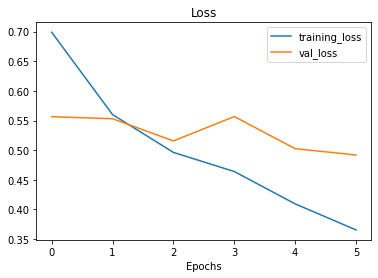

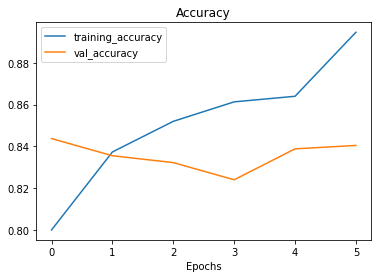

In [ ]:
# Check out the loss curves for fine tune model
plot_loss_curves(history_fine_10_percent_data_aug)

The *plot_loss_curves* function works great with models which have been only fit once, however, we want something to compare one series of running fit() with another (i.e. before and after fine-tuning)

In [ ]:
# Let's create a function to compare training histories.
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compare two TensorFlow History objects.
  """

  # Get original history measurements
  acc= original_history.history["accuracy"]
  loss= original_history.history["loss"]

  val_acc= original_history.history["val_accuracy"]
  val_loss= original_history.history["val_loss"]

  # Combine original_history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")





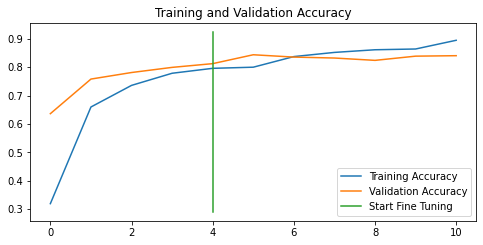

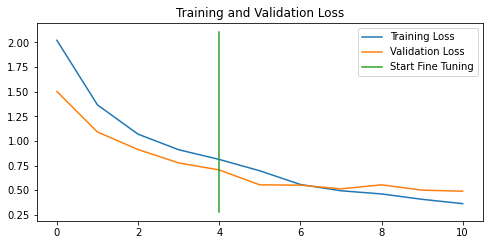

In [ ]:
compare_historys(history_10_percent_data_aug, history_fine_10_percent_data_aug)

## Model 4 : Fine Tuning and existing model on all of the data

In [ ]:
# Download and unzip 10 classes of Food101 data with all images.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-12-05 14:26:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.128, 74.125.70.128, 74.125.201.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   171MB/s    in 2.9s    

2021-12-05 14:26:57 (171 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test directories
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with now
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 

In [ ]:
# Setup data inputs.
import tensorflow as tf
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE )

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Evaluate model_2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.4846 - accuracy: 0.8340


[0.4845637083053589, 0.8339999914169312]

In [ ]:
results_fine_tune_10_percent

[0.4845637083053589, 0.8339999914169312]

### To train a fine-tune model (model_4) we need to revert model_2 back to its feature extraction weights.


In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evalaute our model 2 now.
model_2.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.6957 - accuracy: 0.8020


[0.6957497000694275, 0.8019999861717224]

In [ ]:
# Check which layers are tunable in the whole model.
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2d True
4 output_layer True


In [ ]:
# Recompile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Continue to train and fine-tune the model to all of our data.
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="Transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: Transfer_learning/full_10_classes_fine_tune_last_10/20211205-144750
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


235/235 [==============================] - 94s 364ms/step - loss: 0.7392 - accuracy: 0.7625 - val_loss: 0.3843 - val_accuracy: 0.8766
Epoch 6/10
235/235 [==============================] - 75s 318ms/step - loss: 0.5937 - accuracy: 0.8103 - val_loss: 0.3457 - val_accuracy: 0.8898
Epoch 7/10
235/235 [==============================] - 71s 301ms/step - loss: 0.5391 - accuracy: 0.8293 - val_loss: 0.3044 - val_accuracy: 0.8964
Epoch 8/10
235/235 [==============================] - 64s 271ms/step - loss: 0.4842 - accuracy: 0.8420 - val_loss: 0.3051 - val_accuracy: 0.8980
Epoch 9/10
235/235 [==============================] - 62s 263ms/step - loss: 0.4577 - accuracy: 0.8515 - val_loss: 0.2532 - val_accuracy: 0.9178
Epoch 10/10
184/235 [======================>.......] - ETA: 12s - loss: 0.4243 - accuracy: 0.8667